In [1]:
import MGTomo.model as mgmodel
import MGTomo.functions as fcts
from scipy import interpolate
import numpy as np
import matplotlib.pyplot as plt
import h5py
from skimage.transform import rescale, resize

import pylops
import sys
import pandas as pd

In [2]:
i_id = 0
multi_grid = True
tau = [1.0, 2.0, 1.0, 4.0][i_id]
max_levels = 5
maxIter = [1,1,1,1,1]

### Prepare Data

In [3]:
# load image
images = ['vessel','gear','shepp', 'roux']
with h5py.File('images.h5','r') as f:
    x_orig = np.array(f[images[i_id]]) # shepp, vessel, gear
    
print(f'name={images[i_id]}, shape={x_orig.shape}, dtype={x_orig.dtype}')

name=vessel, shape=(1023, 1023), dtype=float64


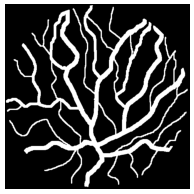

In [4]:
plt.figure(dpi=50)
plt.imshow(x_orig, cmap='gray')
plt.axis('off')
plt.show()

In [5]:
model = mgmodel.astra_model(1023,{'mode' : 'line', 'num_angles' : 200, 'level_decrease' : 1})

fine_dim = model.dim
A = [model.proj_factory(fine_dim)]
b = [A[0].matvec(x_orig)]
level = {int(np.sqrt(A[0].shape[1])): 0}

for i in range(1,max_levels+1):
    corse_dim = model.reduce_dim(fine_dim)
    A.append(model.proj_factory(corse_dim))
    b.append(model.reduce_rhs(b[-1], fine_dim, corse_dim))
    level.update({int(np.sqrt(A[i].shape[1])): i})
    fine_dim=corse_dim
    

In [6]:
print(level)

{1023: 0, 511: 1, 255: 2, 127: 3, 63: 4, 31: 5}


In [7]:
for i in range(max_levels+1):
    assert b[i].shape[0]*b[i].shape[1] == A[i].shape[0], 'dimension mismatch'
    print(f'level {i}:', b[i].shape[0]*b[i].shape[1], A[i].shape[0], np.sqrt(A[i].shape[1]))

level 0: 204600 204600 1023.0
level 1: 102200 102200 511.0
level 2: 51000 51000 255.0
level 3: 25400 25400 127.0
level 4: 12600 12600 63.0
level 5: 6200 6200 31.0


### Riemannian Geometry

In [8]:
def myexp(x):
    # helper function for a save exponential function
    return np.exp(np.minimum(np.maximum(x, -50.0),50.0))

def rectify(y, eps=1e-10):
    # normalization:
    y[y < eps] = eps
    y[y > 1-eps] = 1-eps
    
    return y

def bilinear_interpolation(v):
    inter = interpolate.RegularGridInterpolator((np.arange(1,2*v.shape[0],2), np.arange(1,2*v.shape[1],2)), v, method='linear', bounds_error=False, fill_value=0.0)
    xx, yy = np.meshgrid(np.arange(0,2*v.shape[0]+1), np.arange(0,2*v.shape[1]+1))
    return inter((yy,xx))

def bilinear_interpolation_op(v):
    
    vp = np.pad(v,(0, 1))
    nx, ny = vp.shape
    
    x_coords = np.arange(0,nx-1.5,0.5)
    y_coords = np.arange(0,ny-1.5,0.5)

    yy, xx = np.meshgrid(x_coords, y_coords)
    target_coords = (xx.reshape(-1), yy.reshape(-1))
    
    Bop = pylops.signalprocessing.Bilinear(target_coords, (nx,ny))
    
    u = Bop * vp.reshape(-1)
    u = u.reshape(len(x_coords), len(y_coords))
    u = np.pad(u,1)
    
    return u

def bilinear_interpolation_adj(u):
    
    nx, ny = u.shape
    nx = nx//2 + 1
    ny = ny//2 + 1
    
    x_coords = np.arange(0,nx-1.5,0.5)
    y_coords = np.arange(0,ny-1.5,0.5)

    yy, xx = np.meshgrid(x_coords, y_coords)
    target_coords = (xx.reshape(-1), yy.reshape(-1))
    
    Bop = pylops.signalprocessing.Bilinear(target_coords, (nx,ny))
    
    v = Bop.T * u[1:-1,1:-1].reshape(-1)    
    v = v.reshape(nx, ny)
    v = v[:-1, :-1]
    
    return v

def exp(v, x=None):
    # exponential map on B, exp_x(v)
    
    if x is None:
        x = 0.5
    
    p = myexp(v/(x*(1-x)))
    y = (x*p)/(1-x+x*p)

    # epsilon normalization
    y = rectify(y)
    
    return y

def exp_inv(y, x=None):
    # inverse exponential map on B, exp^{-1}_x(y)
    
    if x is None:
        x = 0.5
    
    return x*(1-x)*np.log((1-x)*y/(x*(1-y)))

def R(y):
    # fine y --> coarse x
    # restiction from B_n to B_m
    x =  y[1:-1:2, 1:-1:2]
    return x

def P(x):
    # coarse x --> fine y
    # prolongation from B_m to B_n

    v = np.log(x/(1-x))   
    y = myexp( bilinear_interpolation(v) )
    y = y / (1 + y)
    
    #y[1:-1:2, 1:-1:2] = x
    
    return y

def TP(u, x=None):
    # coarse (x,u) --> fine (y,v)
    # vector transport prolongation from TB_m to TB_n 

    if x is None:
        x = 0.5*np.ones_like(u)
        
    Px = P(x)
    Gni_Px = Px*(1-Px)
    Gm_x = 1/(x*(1-x))
    v = Gni_Px*bilinear_interpolation(Gm_x*u) # dP_x
    
    #v[1:-1:2, 1:-1:2] = u
    
    return v

def TR(v, y=None):
    # fine (y,v) --> coarse (x,u)
    # vector transport restiction from TB_n to TB_m
    
    if y is None:
        y = 0.5*np.ones_like(v)
        
    x = R(y)
    Px = P(x)
    Gni_Px = Px*(1-Px)
    Gn_y = 1/(y*(1-y))
    
    u = bilinear_interpolation_adj(Gni_Px*Gn_y*v) # dR_y
   
    return u

def Rgrad(v, y):
    return y*(1-y)*v
    
def Rnorm(v, y):
    return np.linalg.norm(1/np.sqrt((y*(1-y)))*v, 'fro')

def Rmetric(u, v, y):
    return np.sum(1/(y*(1-y))*u*v, axis=(0,1))

### Objective

In [9]:
lbd = 0.5 # lambda for regularization of objective
rho = 0.01 # smoothing parameter for HuberTV


def f(y, rgrad = True):

    h = level[y.shape[0]]
    val, grad = fcts.kl_distance_smooth_tv(y,A[h],b[h],rho,lbd)
    
    if rgrad:
        grad = Rgrad(grad, y)
    
    return val, grad

def coarse_f(x, y0, rgrad = True):
    
    x0 = R(y0)
    
    val_f_y0, grad_f_y0 = f(y0)
    val_f_x0, grad_f_x0 = f(x0)
    val_f_x, grad_f_x = f(x)
    
    # objective value
    v = exp_inv(x, x0)
    val = val_f_x - np.sum(v*grad_f_x0, axis=(0,1)) + np.sum(TP(v,x0)*grad_f_y0, axis=(0,1))
    
    # Riemannian gradient
    Rg = Rgrad(grad_f_x, x) - Rgrad(grad_f_x0, x0) + TR(Rgrad(grad_f_y0, y0), y0)
    
    return val, Rg

def adjust_dim_x(x, y0):
    
    while 2*x.shape[0]+1 < y0.shape[0]:
        x = P(x)
    
    return x

def adjust_dim_y(x, y0):
    
    while 2*x.shape[0]+1 < y0.shape[0]:
        y0 = R(y0)
    
    return y0

def coarsen_fn(fh, x, y0, rgrad = True):
    
    y0 = adjust_dim_y(x, y0)
    x0 = R(y0)
    
    val_f_y0, grad_f_y0 = fh(y0)
    val_f_x0, grad_f_x0 = fh(x0)
    val_f_x, grad_f_x = fh(x)
    
    
    # objective value
    v = exp_inv(x, x0)
    val = val_f_x - np.sum(v*grad_f_x0, axis=(0,1)) + np.sum(TP(v,x0)*grad_f_y0, axis=(0,1))
    
    # Riemannian gradient
    Rg = Rgrad(grad_f_x, x) - Rgrad(grad_f_x0, x0) + TR(Rgrad(grad_f_y0, y0), y0)
    
    return val, Rg
    

In [10]:
y = rectify(x_orig)
x = R(y)
z = R(x)
zz = R(z)

f1 = lambda p: coarsen_fn(f, p, y)
f2 = lambda p: coarsen_fn(f1, p, x)
f2(z)[-1].shape

(255, 255)

### Algorithm

In [11]:
def MG_condition_R(y, y0):
    
    kappa = 0.49 # 0.49
    epsilon = 1e-3    
    
    _, Rg = f(y)
      
    a = Rnorm(TR(Rg,y),R(y))
    b = Rnorm(Rg,y)
    c = ((np.linalg.norm(y0-y,'fro')**2)/y.size)
    
    cond = a >= kappa*b and a >= epsilon and c >= epsilon
    
    #print(f'kappa < {a / b}, epsilon < {c}' )
    
    return cond

def MG_condition_E(y, y0):
    
    kappa = 0.49 # 0.49
    epsilon = 1e-3

    _, grad = f(y, rgrad=False)
      
    a = np.linalg.norm(R(grad), 'fro')
    b = np.linalg.norm(grad, 'fro')
    c = ((np.linalg.norm(y0-y,'fro')**2)/y.size)
    
    cond = a >= kappa*b and a >= epsilon and c >= epsilon
    
    #print(f'kappa < {a / b}, epsilon < {c}' )
    
    return cond

def Rg_descent_step(fun, x, h=None, mode='a'):
       
    ### first
    #beta = 0.5 # 0.05
    #sigma = 1e-6 bis 1e-6
    #alpha = 0.2 # 0.02
    
    if mode == 'b':
        ### balanced
        sigma = 0.5
        beta = 0.9
        alpha = 2.0/beta

    elif mode == 'a':
        ### aggresive
        sigma = 0.5
        beta = 0.6
        alpha = tau/beta
        
    elif mode == 'j':
        ### jan
        sigma = 1e-4
        beta = 0.8
        alpha = tau/beta
    else:
        print(f'not supported mode {mode}')

        
        
    f_x, Rg_x = fun(x)
    
    if h is None:
        h = -Rg_x  
    
    x_new = exp(alpha*h, x)
    f_new, _ = fun(x_new)
        
    dgk = Rmetric(Rg_x, h, x)
 
    while f_new - f_x >  sigma*alpha*dgk and alpha > 1e-7:
        x_new = exp(alpha*h, x)
        f_new, _ = fun(x_new)
        alpha *= beta
            
    y = exp(alpha*h, x)
    
    return y, alpha

def MLO(fh, y, l=0):
    
    x = R(y)
    y_last = y
    
    tab = (l+1)*'\t'
    
    # iterations
    for i in range(maxIter[l]):

        # measure objective value and gradient norm
        val, Rg = fh(y)
        rv = val/val_max
        print((l)*'\t'+f'[{l}] iteration: {i} \t rel obj={rv:0.5f} \t ||grad||={Rnorm(Rg,y):0.5f}')

        if l == 0:
            rel_val[i] = rv
        
        # init iteration and check multigrid condition
        y0, x0 = y, R(y)
        do_mg = multi_grid and MG_condition_E(y, y_last) #and i > 3
        y_last = y

        if do_mg:

            print(tab + f'# start multigrid step on level={l}')

            # build coarse model
            psi = lambda x: coarsen_fn(fh, x, y0)
            
            psi(x0)
            
            if l < max_levels-1:
                #x = MLO(psi, x, l+1)
                x = MLO(fh, x, l+1)

            # find coarse point
            for j in range(1):
                x, _ = Rg_descent_step(psi, x, mode=mode)

            #assert psi(x)[0] < fh(x0)[0], 'psi(x) < f(x_0) does not hold'

            h = TP(exp_inv(x, x0), x0)
            y, alpha = Rg_descent_step(fh, y0, h, mode=mode)
            
            print(tab + f'   update y {y.shape} with alpha = {alpha}\n')
            print(tab + f'# end multigrid step on level={l}')
            
            if l == 0:
                mg_steps.update({i:rel_val[i]})

        print(tab + ' - normal step')
        y, alpha = Rg_descent_step(f, y, mode=mode)

        print(tab + f'   update y {y.shape} with alpha = {alpha}\n')
        
    return y


In [12]:
# initialize
mode='a'

y = 0.5 * np.ones_like(x_orig)

val_max, _ = fcts.kl_distance_smooth_tv(y,A[0],b[0],rho,lbd)
rel_val = np.zeros(maxIter[0])
mg_steps = {}

y = MLO(f, y)

[0] iteration: 0 	 rel obj=1.00000 	 ||grad||=574997.81321
	 - normal step
	   update y (1023, 1023) with alpha = 0.0004701849845759998



In [ ]:
plt.figure(dpi=150)
plt.plot(rel_val)
plt.yscale('log')
plt.title('relative objective')
plt.show()

plt.figure(dpi=150)
plt.imshow(y, cmap='gray')
plt.axis('off')
plt.title('reconstruction')
plt.show()

In [ ]:
if False:
    filename = f'/export/home/matthias/Multigrid_Astra_Python/scripts/create_plots/data_{i_id:02d}.csv'
    if multi_grid:
        tag = 'GEO_MG'
    else:
        tag = 'GEO'

    mg_data = pd.read_csv(filename)

    if tag in mg_data.columns:
        mg_data = mg_data.drop(labels=tag, axis=1)

    geo_data = pd.DataFrame({tag: rel_val})
    df = pd.concat([mg_data, geo_data], axis=1)


    df.to_csv(filename, index=False)

In [ ]:
if False:
    if len(mg_steps):
        file_ML_GEO = f'/export/home/matthias/Multigrid_Astra_Python/scripts/create_plots/data_ML_GEO_{i_id:02d}.csv'

        df_data = pd.DataFrame({'x': mg_steps.keys(), 'y': mg_steps.values()})
        df_data.to_csv(file_ML_GEO, index=False)